# RESNET-18(CNN)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data augmentation and preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)


Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 44.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
# Load a pre-trained ResNet model
cnn = models.resnet18(pretrained=False)  # Use ResNet-18
cnn.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
cnn.maxpool = nn.Identity()
cnn.fc = nn.Linear(cnn.fc.in_features, 10)
cnn = cnn.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn.parameters(), lr=0.001)

# Training loop with loss and accuracy tracking
train_losses = []
val_accuracies = []
val_losses = []

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:


#train and evaluate function
def train_and_evaluate(cnn, train_loader, test_loader, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        # Training phase
        cnn.train()
        running_loss = 0.0
        for img, labels in train_loader:
            img, labels = img.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(img)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        cnn.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for img, labels in test_loader:
                img, labels = img.to(device), labels.to(device)
                outputs = cnn(img)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        # Print epoch metrics
        print(
            f"Epoch {epoch + 1}/{epochs} "
            f"Train Loss: {train_loss:.4f}, "
            f"Val Loss: {val_loss:.4f}, "
            f"Val Accuracy: {val_accuracy:.2f}%"
        )


In [5]:

# Visualization of a batch of images and their labels
def visualize_data(data_loader):
    classes = train_dataset.classes
    img, labels = next(iter(data_loader))
    img = img[:8]
    labels = labels[:8]

    # Unnormalize and convert to numpy
    img = img * 0.5 + 0.5
    img = img.numpy()

    # Plot images
    fig, axes = plt.subplots(1, 8, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(img[i], (1, 2, 0)))
        ax.set_title(classes[labels[i]])
        ax.axis('off')
    plt.show()

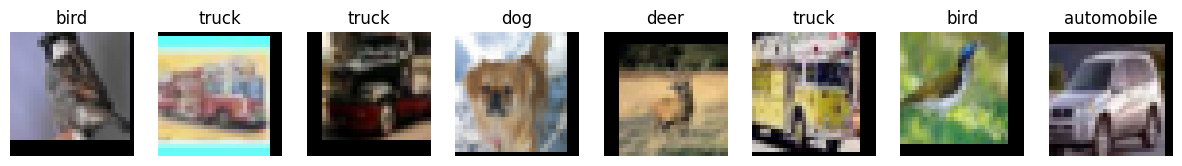

Starting training
Epoch 1/20 Train Loss: 1.3408, Val Loss: 1.0782, Val Accuracy: 62.45%
Epoch 2/20 Train Loss: 0.8757, Val Loss: 0.9947, Val Accuracy: 65.38%
Epoch 3/20 Train Loss: 0.6918, Val Loss: 0.6582, Val Accuracy: 77.09%
Epoch 4/20 Train Loss: 0.5803, Val Loss: 0.9995, Val Accuracy: 70.06%
Epoch 5/20 Train Loss: 0.5058, Val Loss: 0.5186, Val Accuracy: 82.18%
Epoch 6/20 Train Loss: 0.4466, Val Loss: 0.5346, Val Accuracy: 82.30%
Epoch 7/20 Train Loss: 0.4074, Val Loss: 0.5079, Val Accuracy: 83.18%
Epoch 8/20 Train Loss: 0.3674, Val Loss: 0.4560, Val Accuracy: 84.41%
Epoch 9/20 Train Loss: 0.3369, Val Loss: 0.4419, Val Accuracy: 84.93%
Epoch 10/20 Train Loss: 0.3125, Val Loss: 0.4301, Val Accuracy: 85.77%
Epoch 11/20 Train Loss: 0.2897, Val Loss: 0.4314, Val Accuracy: 85.62%
Epoch 12/20 Train Loss: 0.2641, Val Loss: 0.4024, Val Accuracy: 86.56%
Epoch 13/20 Train Loss: 0.2462, Val Loss: 0.4068, Val Accuracy: 86.84%
Epoch 14/20 Train Loss: 0.2261, Val Loss: 0.4035, Val Accuracy: 86.5

In [6]:
# Visualize a batch of data
visualize_data(train_loader)

# Train and evaluate
print("Starting training")
train_and_evaluate(cnn, train_loader, test_loader, criterion, optimizer, epochs=20)


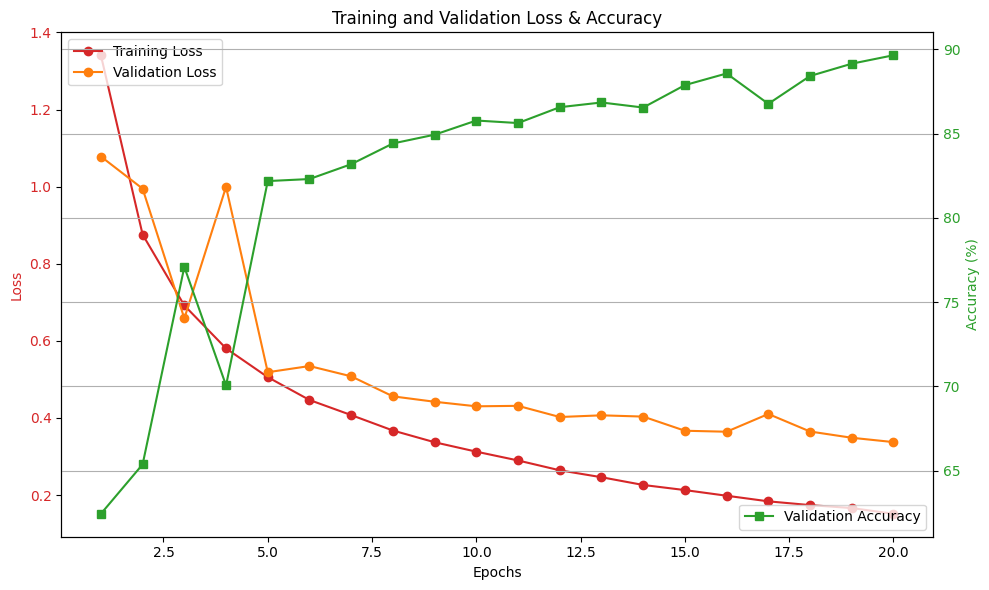

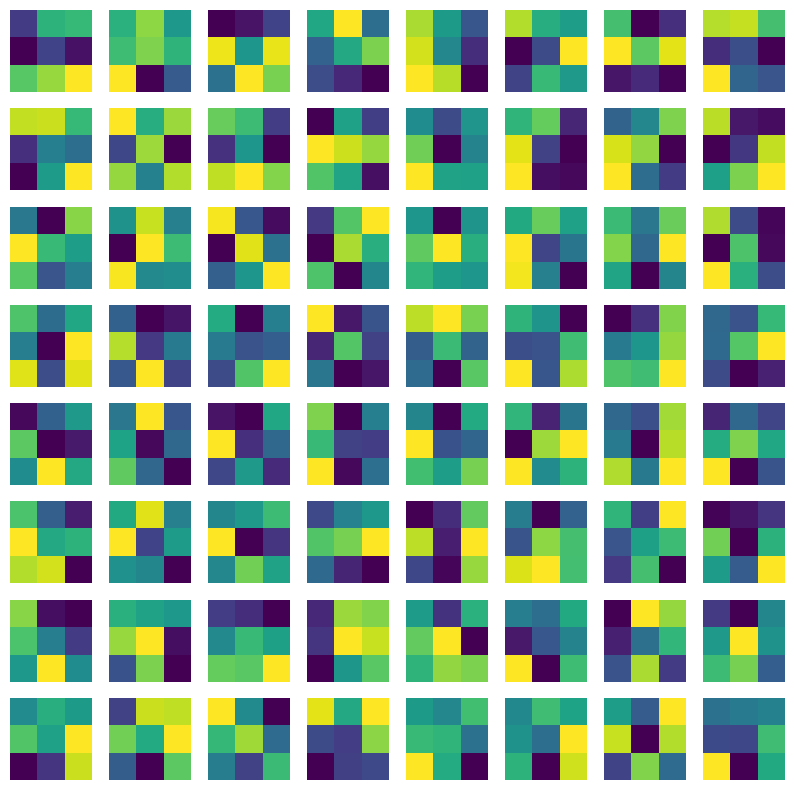

In [7]:
#plot loss and accuracy with two y-axes
def plot_metrics(train_losses, val_losses, val_accuracies, epochs):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training and validation loss on the left y-axis
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='tab:red', linestyle='-', marker='o')
    ax1.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='tab:orange', linestyle='-', marker='o')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis to plot validation accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', color='tab:green')
    ax2.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='tab:green', linestyle='-', marker='s')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Title and legends
    ax1.set_title('Training and Validation Loss & Accuracy')
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='lower right')

    # Show the plot
    plt.grid(True)
    plt.show()

# Visualization of model filters
def visualize_filters(layer):
    filters = layer.weight.data.cpu().numpy()
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < filters.shape[0]:
            ax.imshow(filters[i, 0, :, :], cmap='viridis')
        ax.axis('off')
    plt.show()

# Plot training and validation metrics (loss and accuracy)
plot_metrics(train_losses, val_losses, val_accuracies, epochs=20)

# Visualize filters in the first convolutional layer
visualize_filters(cnn.conv1)


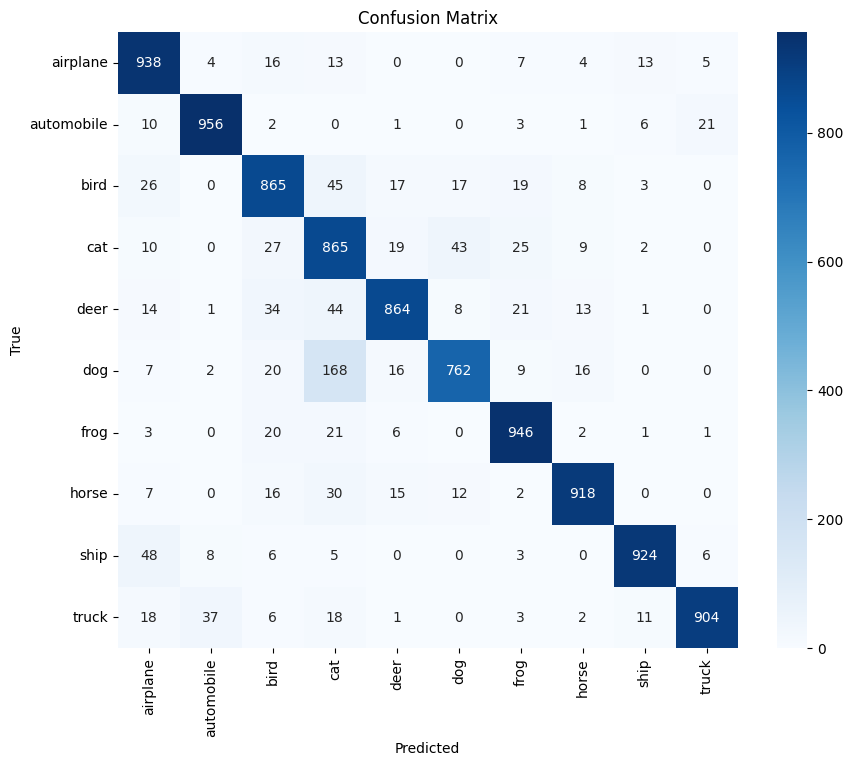

In [8]:
# Function to plot confusion matrix with class labels
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Collect all predictions and true labels
all_preds = []
all_labels = []

cnn.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# CIFAR-10 class labels
class_names = train_dataset.classes

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds, class_names)


# **VIT MODEL**

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm.models.vision_transformer import VisionTransformer
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data augmentation and preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((128, 128)),  # Resize for Vision Transformer
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
torch.backends.cudnn.benchmark = True


train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# Define Vision Transformer model
class CIFARViT(nn.Module):
    def __init__(self):
        super(CIFARViT, self).__init__()
        self.vit = VisionTransformer(
            img_size=128,
            patch_size=16,
            in_chans=3,
            num_classes=10,
            embed_dim=768,
            depth=6,
            num_heads=12,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_rate=0.1,
        )

    def forward(self, x):
        return self.vit(x)

# Initialize the model, loss function, and optimizer
model = CIFARViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# Define warm-up scheduler
def warmup_lr_scheduler(optimizer, warmup_epochs, total_epochs, base_lr):
    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            # Linearly increase LR during warm-up
            return (current_epoch + 1) / warmup_epochs
        else:
            # Use cosine decay after warm-up
            progress = (current_epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            return 0.5 * (1 + torch.cos(torch.tensor(progress * 3.1416)))
    return LambdaLR(optimizer, lr_lambda)


# Scheduler parameters
warmup_epochs = 5
total_epochs = 20
scheduler = warmup_lr_scheduler(optimizer, warmup_epochs, total_epochs, base_lr=0.0001)

# Train and evaluate with metrics tracking
train_losses = []
val_losses = []
val_accuracies = []

# Training loop with mixed precision
def train_with_mixed_precision(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs):
    scaler = torch.cuda.amp.GradScaler()  # Initialize gradient scaler
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Mixed precision forward and backward passes
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():  # Mixed precision for validation
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(100 * correct / total)

        # Step the scheduler
        scheduler.step()

        # Print epoch summary
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, val_accuracies

# Train the model
print("Starting training with mixed precision...")
train_losses, val_losses, val_accuracies = train_with_mixed_precision(
    model, train_loader, test_loader, criterion, optimizer, scheduler, total_epochs
)



Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Starting training with mixed precision...


<ipython-input-9-197cc476fdca>:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Initialize gradient scaler
<ipython-input-9-197cc476fdca>:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-9-197cc476fdca>:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision for validation


Epoch 1/20
Train Loss: 1.7874, Val Loss: 1.5844, Val Accuracy: 42.08%
Epoch 2/20
Train Loss: 1.5376, Val Loss: 1.4262, Val Accuracy: 48.32%
Epoch 3/20
Train Loss: 1.3968, Val Loss: 1.3561, Val Accuracy: 50.42%
Epoch 4/20
Train Loss: 1.3067, Val Loss: 1.2740, Val Accuracy: 53.44%
Epoch 5/20
Train Loss: 1.2338, Val Loss: 1.1761, Val Accuracy: 57.01%
Epoch 6/20
Train Loss: 1.1570, Val Loss: 1.1487, Val Accuracy: 59.11%
Epoch 7/20
Train Loss: 1.0990, Val Loss: 1.0729, Val Accuracy: 61.45%
Epoch 8/20
Train Loss: 1.0358, Val Loss: 1.0273, Val Accuracy: 62.33%
Epoch 9/20
Train Loss: 0.9827, Val Loss: 1.0040, Val Accuracy: 64.23%
Epoch 10/20
Train Loss: 0.9365, Val Loss: 0.9579, Val Accuracy: 65.07%
Epoch 11/20
Train Loss: 0.8828, Val Loss: 0.9419, Val Accuracy: 66.26%
Epoch 12/20
Train Loss: 0.8336, Val Loss: 0.8743, Val Accuracy: 68.73%
Epoch 13/20
Train Loss: 0.7717, Val Loss: 0.8484, Val Accuracy: 69.92%
Epoch 14/20
Train Loss: 0.7083, Val Loss: 0.8326, Val Accuracy: 70.70%
Epoch 15/20
Tra

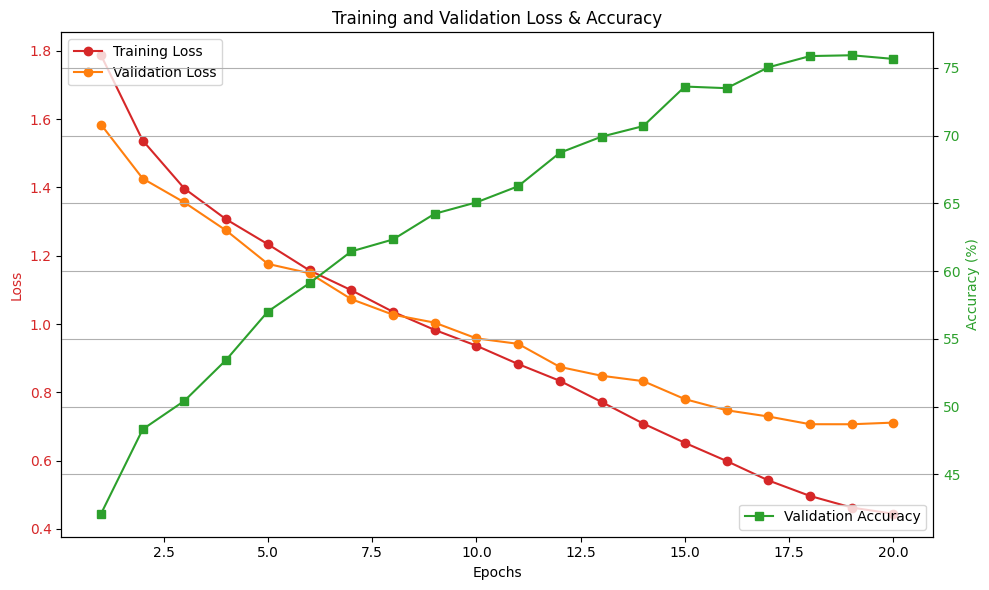

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation loss with validation accuracy on the same graph
def plot_loss_and_accuracy(train_losses, val_losses, val_accuracies, epochs):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training and validation loss on the left y-axis
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='tab:red', linestyle='-', marker='o')
    ax1.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='tab:orange', linestyle='-', marker='o')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis to plot validation accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', color='tab:green')
    ax2.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='tab:green', linestyle='-', marker='s')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Title and legends
    ax1.set_title('Training and Validation Loss & Accuracy')
    fig.tight_layout()  # To ensure the labels do not overlap
    ax1.legend(loc='upper left')
    ax2.legend(loc='lower right')

    # Show the plot
    plt.grid(True)
    plt.show()

# Plot the graph with the data
plot_loss_and_accuracy(train_losses, val_losses, val_accuracies, total_epochs)

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
def visualize_filters(layer):
    filters = layer.weight.data.cpu().numpy()
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < filters.shape[0]:
            ax.imshow(filters[i, 0, :, :], cmap='viridis')
        ax.axis('off')
    plt.show()

In [12]:
# Confusion Matrix
def plot_confusion_matrix(model, test_loader, classes):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

Visualizing filters in the first convolutional layer...


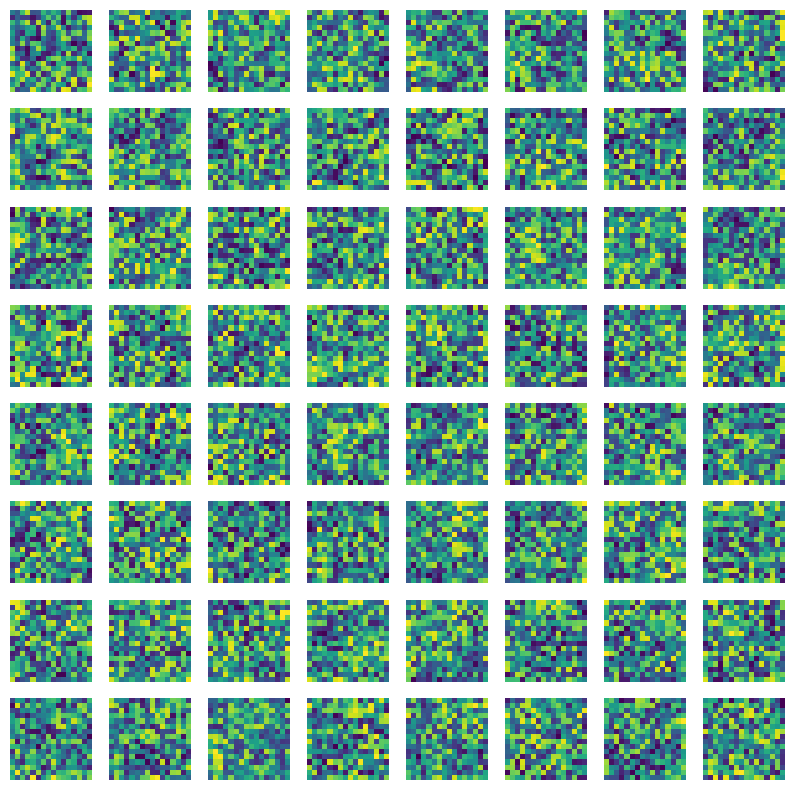

Generating confusion matrix...


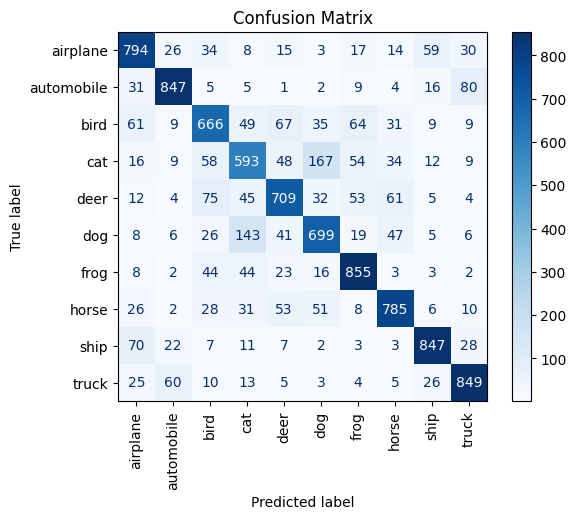

In [13]:

print("Visualizing filters in the first convolutional layer...")
visualize_filters(model.vit.patch_embed.proj)

print("Generating confusion matrix...")
plot_confusion_matrix(model, test_loader, train_dataset.classes)